In [3]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


import time as time

# -------------- SET UP YOUR PATH ------------
# import sys
# sys.path.append("~/OneDrive/ExtendedProject/Code/Weak SDE approximation")

import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Numba code working for the underdamped case

#### Overdamped 
In this notebook, I present the theory underpinning the adaptive method of interest. We aim at generating samples from both the transient and long term distribution of the SDE: 
$$
dx(t) = -U'(x(t)) dt + \sqrt{2 \tau} dW(t).
$$

We have shown above that one can obtain a transformed SDE of the form: 
$$
dy(s) = -U'(y(s)) g(y(s)) ds + \tau g'(y(s)) ds+ \sqrt{2 \tau g(y(s))} dW(s)
$$
with some conditions on $g(x)$, which has the same long term distribution.  

While we have shown that those tansformed SDEs have the same invariant distribution than the non transformed one, nothing is said from their transient distribution. In order to obtain invariant distribution, one needs to let time runs to infinity. Below I present the Euler-Maruyama methods applied to those two SDEs, using the bond problem. 

### Algorithms
#### Non adaptive
To simulate samples from: 
$$
dx(t) = -U'(x(t)) dt + \sqrt{2 \tau} dW(t),
$$
we set $X_0 = x(0)$ and compute $X_{n} \approx x(t_n)$ with $t_n = n \frac{T}{\Delta t}$, with $n=0,1, \dots N$. The time counts taken is computed using $\hat{ \Delta  t} =g(X_n) \Delta t$.
$$
X_{n+1} = X_n - U'(X_n) \Delta t +  \sqrt{2 \tau} \Delta W(t)_n,
$$
and run time forward using a count $t = t+ g(X_n) \Delta t$. 

#### Adaptive by applying euler maruyama to transformed SDE

To simulate samples from 
$$
dy(s) = -U'(y(s)) g(y(s)) ds + \tau g'(y(s)) ds+ \sqrt{2 \tau g(y(s))} dW(s)
$$
we set $Y_0 = y(0)$ and compute $Y_{i} \approx y(t_i)$ with $t_i = i \frac{T}{\Delta t}$, with $i=0,1, \dots N$.
$$
Y_{i+1} =Y_i -U'(Y_i) g(Y_i) \Delta s + \tau g'(Y_i) \Delta s+ \sqrt{2 \tau g( Y_i)} \Delta s_n
$$
and run time forward using a count $t = t+\Delta t$. 


#### Adaptive by rescaling time count and applying euler maruyama to non transformed
To simulate samples from: 
$$
dx(t) = -U'(x(t)) dt + \sqrt{2 \tau} dW(t),
$$
we set $\tilde{X}_0 = x(0)$ and compute $\tilde{X}_{j} \approx x(t_j)$ with $\tilde{t}_J = \sum_{j=0}^{J} \Delta \tilde{t}_j =\sum_{j=0}^{J} g(\tilde{X}_j) \Delta t$, with $j=0,1, \dots J$, such that $\sum_{j=0}^{J} \Delta \tilde{t}_j$ reaches $T$.
$$
\tilde{X}_{j+1} = \tilde{X}_j - U'(\tilde{X}_j) \Delta \tilde{t} +  \sqrt{2 \tau} \Delta \tilde{W}_j,
$$
and run time forward using a count $\tilde{t}_j = \tilde{t}_j+\Delta \tilde{t}_j$ where $ \Delta \tilde{t}_j = \Delta t g(\tilde{X}_j)$.

Below we compare those 3 strategies accross times. 

In [4]:
from numba import jit,njit,vectorize, float64, int32, boolean
import numba as nb
import numpy as np

##############
# Parameters #
##############
M=2
m=0.5
# includeD=False # if 1 include divergence term
printskip=10
list_counts = np.array([100,200,500,900,5000,10000]) #to run small h simulation
# list_counts = np.array([20.,120.,220.,320.,420.])*10

# list_counts = np.array([1,2,3,4,5,6,7,8,9])


lenls = len(list_counts)
########################
# Potential parameters #
########################

def U(x):
    """
    potential of -the infinite double well
    """
    x2 = x*x
    
    return (1/(2*x2)+x2)
    
# define the gradV function 
@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

########################
#  Adaptive function G #
########################
@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

# ###################################
# # * Using the hessian definition *#
# ###################################
# @njit(float64(float64))
# def getg_hessian(x): #,dtmin, dtmax, R):
#     gi2 = np.power(x,8)/9
#     xi = np.sqrt(m*m+gi2)
#     g=1./(1./M+1./xi)
#     return g

# @njit(float64(float64))
# def getgprime_hessian(x):
#     gi2 = np.power(x,8)/9
#     xi = np.sqrt(gi2+m*m)
#     x7=gi2/x*4
#     Mxi =np.power((M+xi),2)
#     gprime= x7*M*M/(Mxi*xi)
#     return gprime

####################
#  Numerical method#
####################  

@njit(float64[:,:](int32,float64,float64,int32))
def one_traj_ada(Nt,dt,tau,include_ada):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of counts to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    x = 2 # initial value
    t=0 # initialise time at t=0
    count=0.

    #set up vectors to save results 
    # size_save = int(Nt/printskip)
    size_save = lenls      #int(Nt/printskip)

    ctxg_list = np.zeros((size_save,5))
    save_i=0 

    for count in range(Nt):
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)

        # No adaptivity   
        ###############
        if include_ada==0:
            g=1
            gp=0
            gdt=g*dt
            t+=dt

        # EM applied to transformed SDE and counts using t+=dt  
        #####################################################
        elif include_ada==1:
            g=getg(x)
            gp=getgprime(x)
            gdt=g*dt
            t+=dt

        # EM applied to non transformed SDE but rescale counts
        #####################################################
        elif include_ada==2:
            g=getg(x)
            gp=0 #do not want to add this term so set it to 0. 
            gdt=g*dt
            t+=gdt

        # Compute the values of next count 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*gdt+np.sqrt(tau*gdt*2)*b1+dt*tau*gp
        count+=1

        #****************************
        #* Save (x) and update time *
        #****************************
        if count == list_counts[save_i]:
            ctxg_list[save_i,0]=count
            ctxg_list[save_i,1]=t
            ctxg_list[save_i,2]=x
            ctxg_list[save_i,3]=g
            ctxg_list[save_i,4]=gp

            save_i+=1
    
    return (ctxg_list)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def nsample_ada(n_samples,Nt,dt,tau,include_ada): # Function is compiled and runs in machine code

    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    Nt: int 
        number of run
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    include_ada: int
        if include_ada==0 No adaptivity 
        if include_ada==1 EM applied to transformed SDE and counts using t+=dt  
        if include_ada==2 EM applied to non transformed SDE but rescale counts t+=gdt

    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    nsample_pertraj =  lenls #int(Nt/printskip)
    simctxdt_list=np.zeros((n_samples*nsample_pertraj,6))
    ones_nsample=np.ones(nsample_pertraj)

    for j in range(n_samples):
        ctxg_list =one_traj_ada(Nt,dt,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        simctxdt_list[start_i:end_i,1:6]=ctxg_list
        simctxdt_list[start_i:end_i,0]=ones_nsample*j
    return simctxdt_list

# compile
# y=nsample_ada(1,2,0.1,0.1,0) 

nsample_ada(2,100,0.1,0.1,1) 



array([[  0.        , 100.        ,  10.        ,   0.81842699,
          0.78935296,   1.14921618],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  1.        , 100.        ,  10.        ,   0.64845879,
          0.53449509,   0.7691657 ],
       [  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0. 

In [5]:
n_samples=10**5
Nt=500+1
tau=0.1
h=0.01

# if include_ada==0 No adaptivity 
include_ada=0   
%time ynoada= nsample_ada(n_samples,Nt,h,tau,include_ada)

# # if include_ada==1 EM applied to transformed SDE and counts using t+=dt  
include_ada=1
%time yemtotranssde= nsample_ada(n_samples,Nt,h,tau,include_ada)

# if include_ada==2 EM applied to non transformed SDE but rescale counts t+=gdt
include_ada=2
%time yemtonontranssde= nsample_ada(n_samples,Nt,h,tau,include_ada)


CPU times: user 2min 38s, sys: 371 ms, total: 2min 38s
Wall time: 14.5 s
CPU times: user 4min 17s, sys: 557 ms, total: 4min 18s
Wall time: 23.2 s
CPU times: user 3min 2s, sys: 364 ms, total: 3min 3s
Wall time: 16.1 s


In [5]:
n_samples=10**5
tau=0.1
h=0.001
Nt = 5000+1

# if include_ada==0 No adaptivity 
include_ada=0   
%time ynoada_true= nsample_ada(n_samples,Nt,h,tau,include_ada)
df_ynoada_true = pd.DataFrame(ynoada_true,columns=["sim","count","t","x","g","gp"])
df_ynoada_true

CPU times: user 7min 55s, sys: 355 ms, total: 7min 55s
Wall time: 41.5 s


,sim,count,t,x,g,gp
0,0.0,200.0,0.2,1.741633,1.0,0.0
1,0.0,1200.0,1.2,0.725240,1.0,0.0
2,0.0,2200.0,2.2,0.790243,1.0,0.0
3,0.0,3200.0,3.2,0.789404,1.0,0.0
4,0.0,4200.0,4.2,0.939296,1.0,0.0
...,...,...,...,...,...,...
499995,99999.0,200.0,0.2,1.497090,1.0,0.0
499996,99999.0,1200.0,1.2,0.673478,1.0,0.0
499997,99999.0,2200.0,2.2,0.976729,1.0,0.0
499998,99999.0,3200.0,3.2,0.955523,1.0,0.0


In [5]:
# np.savetxt("ynoada_ns105Nt500tau01h001.txt", ynoada)
# np.savetxt("yemtotranssde_ns105Nt500tau01h001.txt", yemtotranssde)
# np.savetxt("yemtonontranssde_ns105Nt500tau01h001.txt", yemtonontranssde)
# np.savetxt("ynoada_ns105Nt5000tau01h0001.txt", ynoada_true)

# ynoada=np.loadtxt("ynoada_ns105Nt500tau01h001.txt")
# yemtotranssde=np.loadtxt("yemtotranssde_ns105Nt500tau01h001.txt")
# yemtonontranssde=np.loadtxt("yemtonontranssde_ns105Nt500tau01h001.txt")
ynoada_true=np.loadtxt("ynoada_ns105Nt500tau01h00001.txt")


# ynoada=np.loadtxt("ynoada_ns105Nt1000tau01h001.txt")
# yemtotranssde=np.loadtxt("yemtotranssde_ns105Nt1000tau01h001.txt")
# yemtonontranssde=np.loadtxt("yemtonontranssde_ns105Nt1000tau01h001.txt")
# ynoada_true=np.loadtxt("ynoada_ns105Nt1000tau01h0001.txt")


FileNotFoundError: ynoada_ns105Nt500tau01h00001.txt not found.

In [6]:
n_samples=10**5
Nt=10000+1
tau=0.1
h=0.01

# if include_ada==0 No adaptivity 
include_ada=0   
%time ynoada= nsample_ada(n_samples,Nt,h,tau,include_ada)

# # if include_ada==1 EM applied to transformed SDE and counts using t+=dt  
include_ada=1
%time yemtotranssde= nsample_ada(n_samples,Nt,h,tau,include_ada)

# if include_ada==2 EM applied to non transformed SDE but rescale counts t+=gdt
include_ada=2
%time yemtonontranssde= nsample_ada(n_samples,Nt,h,tau,include_ada)

CPU times: user 26min 13s, sys: 2.45 s, total: 26min 16s
Wall time: 2min 19s
CPU times: user 48min 41s, sys: 4.19 s, total: 48min 45s
Wall time: 4min 17s
CPU times: user 1h 4min 48s, sys: 6.01 s, total: 1h 4min 54s
Wall time: 6min 8s


In [83]:
np.savetxt("ynoada_ns105Nt104tau01h001.txt", ynoada)
np.savetxt("yemtotranssde_ns105Nt104tau01h001.txt", yemtotranssde)
np.savetxt("yemtonontranssde_ns105Nt104tau01h001.txt", yemtonontranssde)


In [7]:
df_ynoada = pd.DataFrame(ynoada,columns=["sim","count","t","x","g","gp"])
df_yemtotranssde = pd.DataFrame(yemtotranssde,columns=["sim","count","t","x","g","gp"])
df_yemtonontranssde = pd.DataFrame(yemtonontranssde,columns=["sim","count","t","x","g","gp"])
# df_ynoada_true = pd.DataFrame(ynoada_true,columns=["sim","count","t","x","g","gp"])

In [10]:
## Get a list of the counts taken in each scheme
print(df_ynoada['count'].unique())
print(df_yemtotranssde['count'].unique())
print(df_yemtonontranssde['count'].unique())
# print(df_ynoada_true['count'].unique())
list_count = df_ynoada['count'].unique()


[  100.   200.   500.   900.  5000. 10000.]
[  100.   200.   500.   900.  5000. 10000.]
[  100.   200.   500.   900.  5000. 10000.]


In [184]:
df_ynoada

,sim,count,t,x,g,gp
0,0.0,20.0,0.2,1.517326,1.0,0.0
1,0.0,120.0,1.2,0.984244,1.0,0.0
2,0.0,220.0,2.2,0.825812,1.0,0.0
3,0.0,320.0,3.2,0.711232,1.0,0.0
4,0.0,420.0,4.2,0.855733,1.0,0.0
...,...,...,...,...,...,...
499995,99999.0,20.0,0.2,1.513057,1.0,0.0
499996,99999.0,120.0,1.2,0.807718,1.0,0.0
499997,99999.0,220.0,2.2,0.859520,1.0,0.0
499998,99999.0,320.0,3.2,0.996318,1.0,0.0


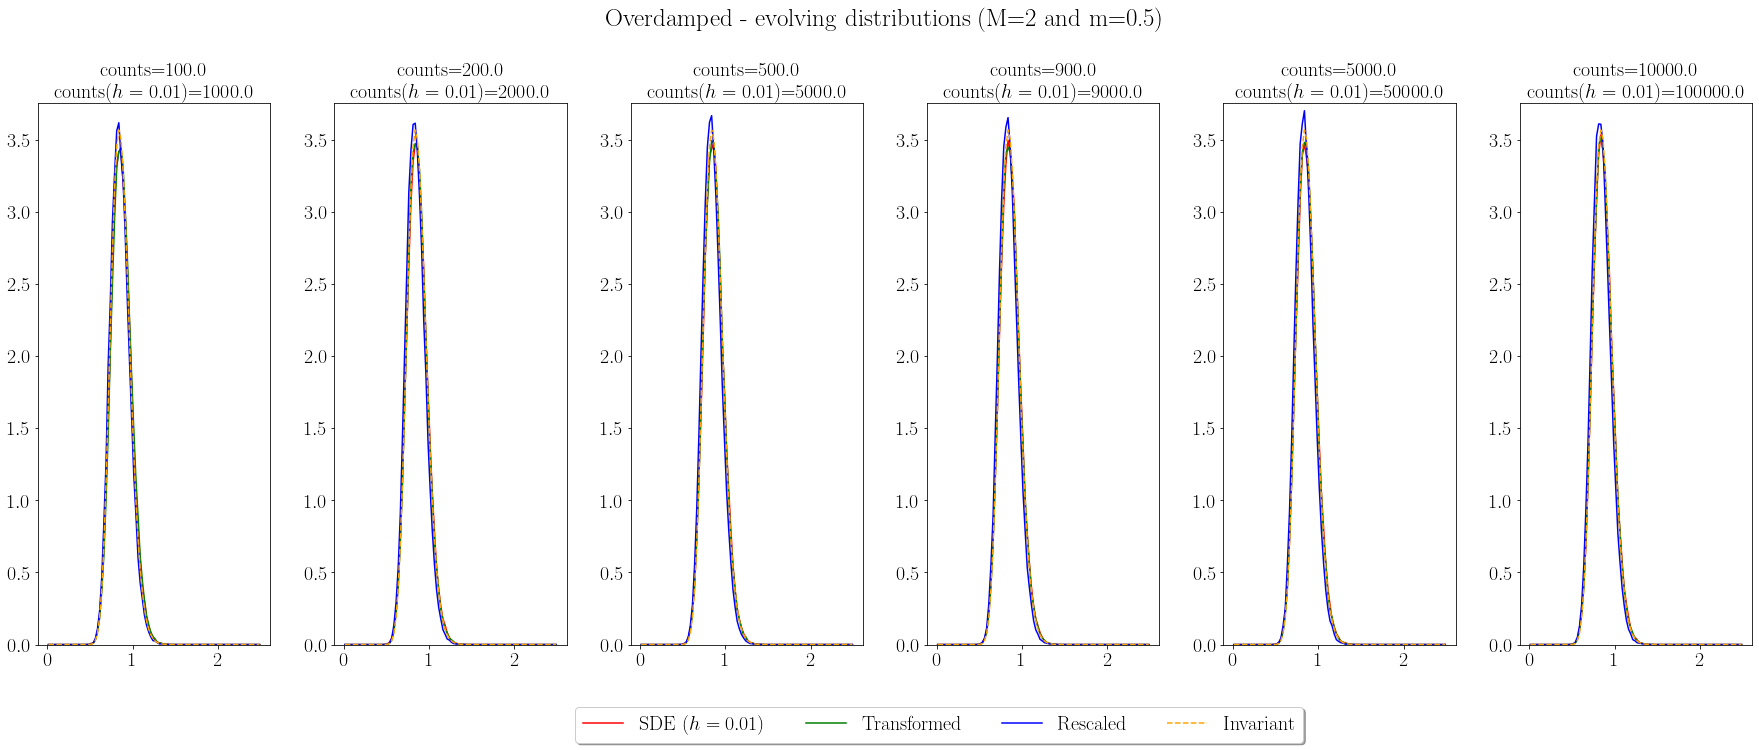

In [11]:
## Set up the plots 
fig, ((axs))= plt.subplots(1,len(list_count),figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Overdamped - evolving distributions (M='+str(M)+' and m=' +str(m)+")", fontsize=25)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
## Loop through the values 
for i in range(len(list_count)):
    
    # List of time
    count_i = list_count[i]
    
    # DF no ada
    df_ynoada_i=df_ynoada[df_ynoada['count']==count_i]
    histogram,bins = np.histogram(df_ynoada_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label='SDE ($h=0.01$)',color="red")

    #DF transformed
    df_yemtotranssde_i=df_yemtotranssde[df_yemtotranssde['count']==count_i]
    histogram,bins = np.histogram(df_yemtotranssde_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label='Transformed',color="green")

    # DF rescaled 
    df_yemtonontranssde_i=df_yemtonontranssde[df_yemtonontranssde['count']==count_i]
    histogram,bins = np.histogram(df_yemtonontranssde_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label='Rescaled',color="blue")

    # # # No ada
    # df_ynoada_true_i=df_ynoada_true[df_ynoada_true['count']==count_i*10]
    # histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
    # midx_q = (bins[0:-1]+bins[1:])/2
    # axs[i].plot(midx_q,histogram,"x",label='SDE ($h=0.001$)',color="magenta")


    # --- Q invariant
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[i].plot(midx_q,rho,'--',label='Invariant',color="orange")
    axs[i].set_title("counts="+str(np.round(count_i,0)) +"\n counts($h=0.01$)="+ str(10*np.round(count_i,0)),fontsize= 20)

    # parameters of axis
    axs[i].set_ylim([0, 3.75])


axs[len(list_count)-1].legend(loc='lower center',bbox_to_anchor=(-2.5, -.2),
          ncol=5, fancybox=True, shadow=True)


fig.savefig('evolving_distrM'+str(M)+"m"+str(m)+"Nt"+str(500)+"h"+str(h)+"tau"+str(tau)+".png")

In [188]:
list_count=np.array([ 20.,220.,420.])

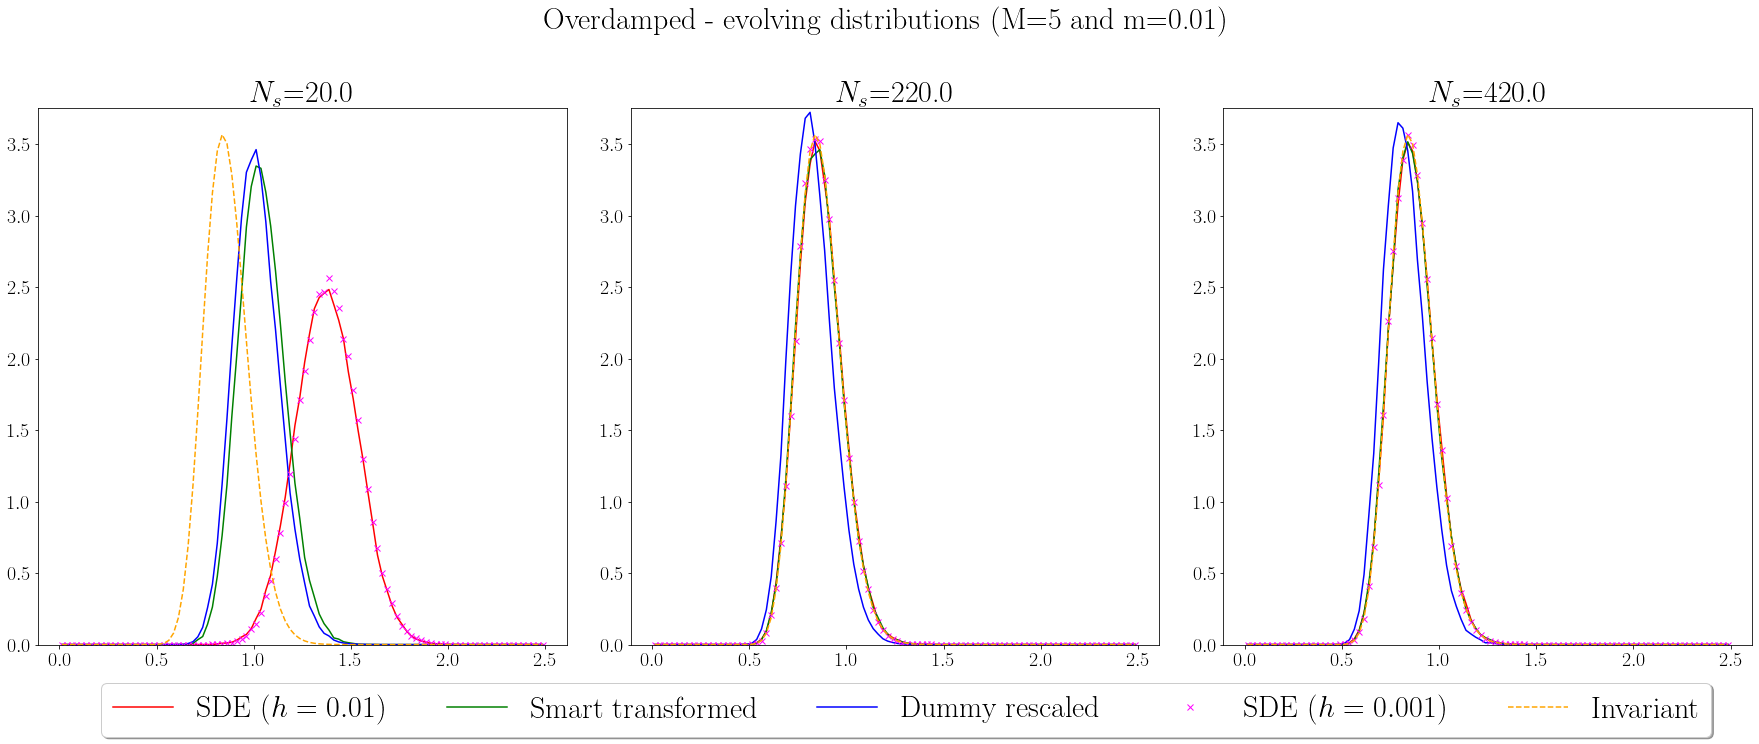

In [204]:
## Set up the plots 
fig, ((axs))= plt.subplots(1,len(list_count),figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Overdamped - evolving distributions (M='+str(M)+' and m=' +str(m)+")", fontsize=30)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
## Loop through the values 
for i in range(len(list_count)):
    
    # List of time
    count_i = list_count[i]
    
    # DF no ada
    df_ynoada_i=df_ynoada[df_ynoada['count']==count_i]
    histogram,bins = np.histogram(df_ynoada_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label='SDE ($h=0.01$)',color="red")

    #DF transformed
    df_yemtotranssde_i=df_yemtotranssde[df_yemtotranssde['count']==count_i]
    histogram,bins = np.histogram(df_yemtotranssde_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label='Smart transformed',color="green")

    # DF rescaled 
    df_yemtonontranssde_i=df_yemtonontranssde[df_yemtonontranssde['count']==count_i]
    histogram,bins = np.histogram(df_yemtonontranssde_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label='Dummy rescaled',color="blue")

    # # No ada
    df_ynoada_true_i=df_ynoada_true[df_ynoada_true['count']==count_i*100]
    histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,"x",label='SDE ($h=0.001$)',color="magenta")


    # --- Q invariant
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[i].plot(midx_q,rho,'--',label='Invariant',color="orange")
    axs[i].set_title("$N_{s}$="+str(np.round(count_i,0)),fontsize=30)
    
    #+"\n $N_{s}$ ($h=0.001$)="+ str(10*np.round(count_i,0)),fontsize= 20)

    # parameters of axis
    axs[i].set_ylim([0, 3.75])


axs[len(list_count)-1].legend(loc='lower center',bbox_to_anchor=(-.6, -.2),
          ncol=5, fancybox=True, shadow=True,fontsize=30)

Number of counts taken to reach a distribution, in the case of the overdamped system, the adaptive is much faster at reaching the invariant distribution. 
Let's look at long term distribution compared to the invariant distribution?

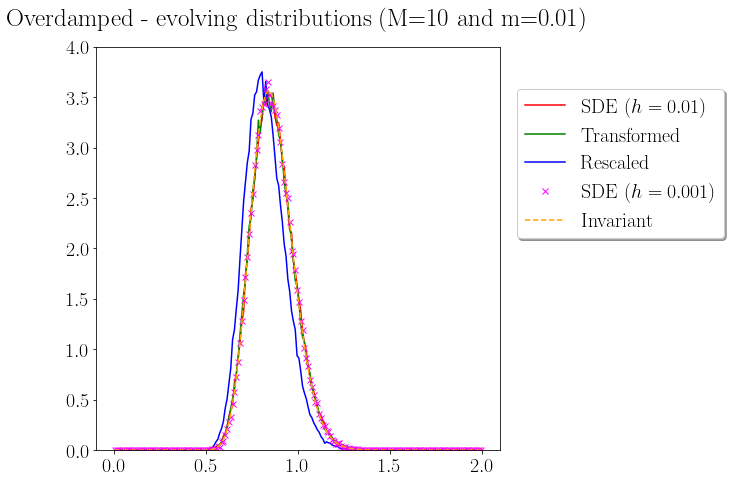

In [20]:
## Set up the plots 
fig, ((axs))= plt.subplots(1,1,figsize=(7,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Overdamped - evolving distributions (M='+str(M)+' and m=' +str(m)+")", fontsize=25)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
## Loop through the values 
    
# List of time
ti = df_ynoada['count'].max()
# * Dataframe using hessian
df_ynoada_i=df_ynoada[df_ynoada['count']==ti]
# * Dataframe using first derivative 
df_yemtotranssde_i=df_yemtotranssde[df_yemtotranssde['count']==ti]
# * Dataframe using no adaptivity 
df_yemtonontranssde_i=df_yemtonontranssde[df_yemtonontranssde['count']==ti]

# * Dataframe 
df_ynoada_true_i=df_ynoada_true[df_ynoada_true['count']==ti*10]
    
nbins=200
# --- Q at time t=ti hessian
histogram,bins = np.histogram(df_ynoada_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,label='SDE ($h=0.01$)',color="red")

# --- Q at time t=ti first derivative
histogram,bins = np.histogram(df_yemtotranssde_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,label='Transformed',color="green")

# --- Q at time t=ti not adaptive
histogram,bins = np.histogram(df_yemtonontranssde_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,label='Rescaled',color="blue")

# --- Q at time t=ti not adaptive
histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,"x",label='SDE ($h=0.001$)',color="magenta")


# --- Q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
axs.plot(midx_q,rho,'--',label='Invariant',color="orange")
# axs.set_title("counts="+str(np.round(ti,3)),fontsize= 20)
axs.set_ylim([0, 4])

axs.legend(loc='lower center',bbox_to_anchor=(1.3, 0.5),
          ncol=1, fancybox=True, shadow=True)



After a fixed number of counts, the rescaled time SDE is not converging towards the invariant distribution. In order to make the rescaled time SDE work, one needs to get a code that evaluates whether the rescaled time reaches the time of interest. We will rewrite the code below. 

Just to have an idea of what is going on in the EM with rescaled time, we plot the distribution of the final times (times reached with rescaled time). 

Text(0.5, 1.0, "Distribution of $g'(x)$ \n in transformed case ")

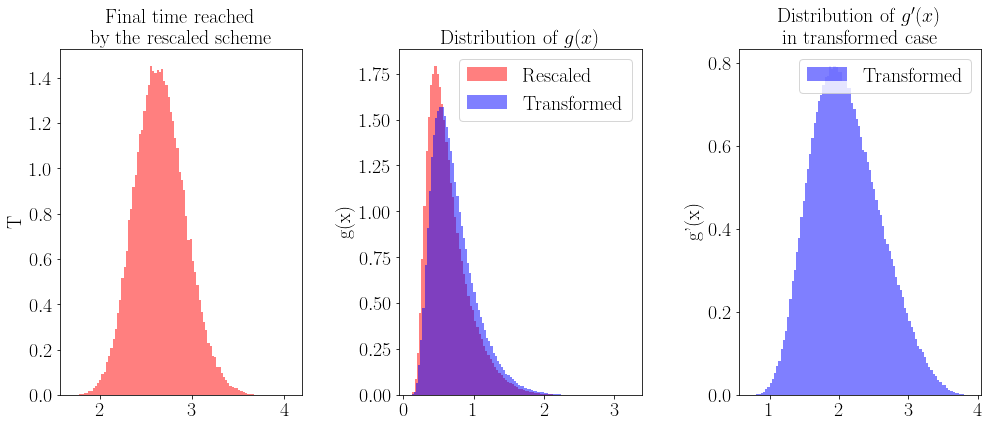

In [25]:

fig, ((ax1,ax2,ax3))= plt.subplots(1, 3,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)


# Non transformed Rescale time 
list_time_rescale=df_yemtonontranssde[df_yemtonontranssde['count']==ti]['t']

# Plot final time reached by the rescaled scheme
var = list_time_rescale
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="No ada",alpha=0.5)
# ax1.set_ylim([0,0.75])
ax1.set_ylabel("T")
ax1.set_title("Final time reached \nby the rescaled scheme")


# Plot values of g reached by rescaled
var =df_yemtonontranssde['g']
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="Rescaled",alpha=0.5)
# ax2.set_ylim([0,0.75])
ax2.set_ylabel("g(x)")

# Plot values of g reached by transformed
var =df_yemtotranssde['g']
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Transformed",alpha=0.5)
# ax2.set_ylim([0,0.75])
ax2.set_ylabel("g(x)")
ax2.legend()
ax2.set_title("Distribution of $g(x)$")


# Plot values of g reached by transformed
var =df_yemtotranssde['gp']
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Transformed",alpha=0.5)
# ax2.set_ylim([0,0.75])
ax3.set_ylabel("g'(x)")
ax3.legend()
ax3.set_title("Distribution of $g'(x)$ \n in transformed case ")


# fig.savefig('distr_final_timeM'+str(M)+"m"+str(m)+"Nt"+str(Nt)+"h"+str(h)+"tau"+str(tau)+".png")

### Does the bias disappear when increasing the number of steps taken?

In [87]:
yemtonontranssde_moresteps=np.loadtxt("yemtonontranssde_ns105Nt104tau01h001.txt")
df_rescaled_moresteps = pd.DataFrame(yemtonontranssde_moresteps,columns=["sim","count","t","x","g","gp"])

In [88]:
yemtotranssde=np.loadtxt("yemtotranssde_ns105Nt104tau01h001.txt")


In [89]:
df_transfo_moresteps = pd.DataFrame(yemtotranssde,columns=["sim","count","t","x","g","gp"])

In [91]:
print(df_rescaled_moresteps['count'].unique())
print(df_yemtonontranssde['count'].unique())

[  100.   200.   500.   900.  5000. 10000.]
[  100.   200.   500.   900.  5000. 10000.]


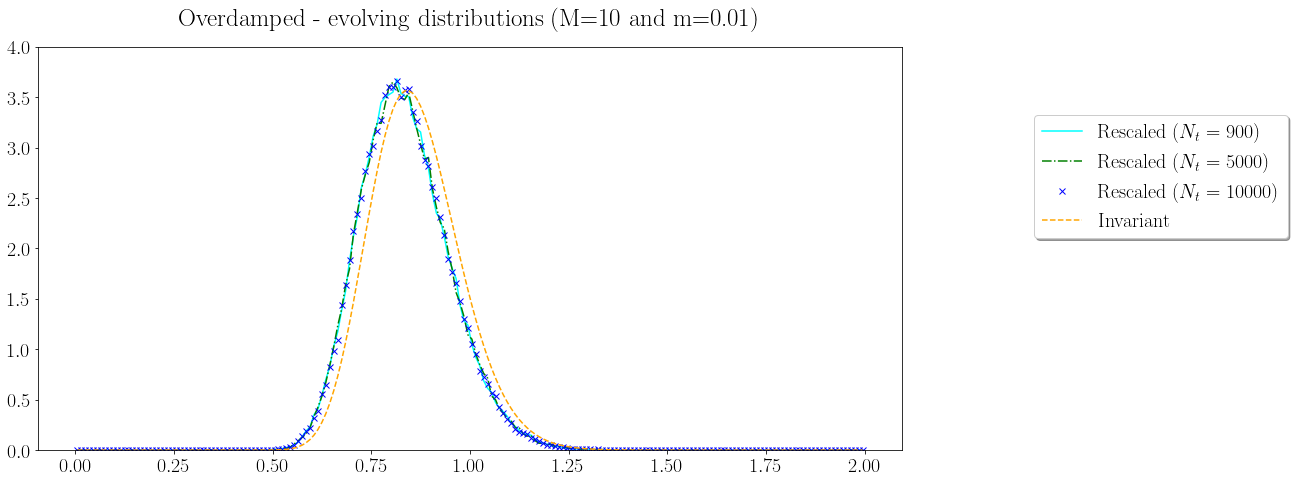

In [65]:
## Set up the plots 
fig, ((ax1))= plt.subplots(1,1,figsize=(15,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Overdamped - evolving distributions (M='+str(M)+' and m=' +str(m)+")", fontsize=25)

## Loop through the values   

nbins=200

# rescaled with Nt=10000
df_rescaled_moresteps_i=df_rescaled_moresteps[df_rescaled_moresteps['count']==900]
histogram,bins = np.histogram(df_rescaled_moresteps_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='Rescaled ($N_t=900$)',color="cyan")

# rescaled with Nt=10000
df_rescaled_moresteps_i=df_rescaled_moresteps[df_rescaled_moresteps['count']==5000]
histogram,bins = np.histogram(df_rescaled_moresteps_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,'-.',label='Rescaled ($N_t=5000$)',color="green")

# rescaled with Nt=10000
df_rescaled_moresteps_i=df_rescaled_moresteps[df_rescaled_moresteps['count']==10000]
histogram,bins = np.histogram(df_rescaled_moresteps_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,"x",label='Rescaled ($N_t=10000$)',color="blue")


# --- Q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Invariant',color="orange")
# axs.set_title("counts="+str(np.round(ti,3)),fontsize= 20)
ax1.set_ylim([0, 4])

ax1.legend(loc='lower center',bbox_to_anchor=(1.3, 0.5),
          ncol=1, fancybox=True, shadow=True)



Text(0.5, 1.0, '$N_t=10000$')

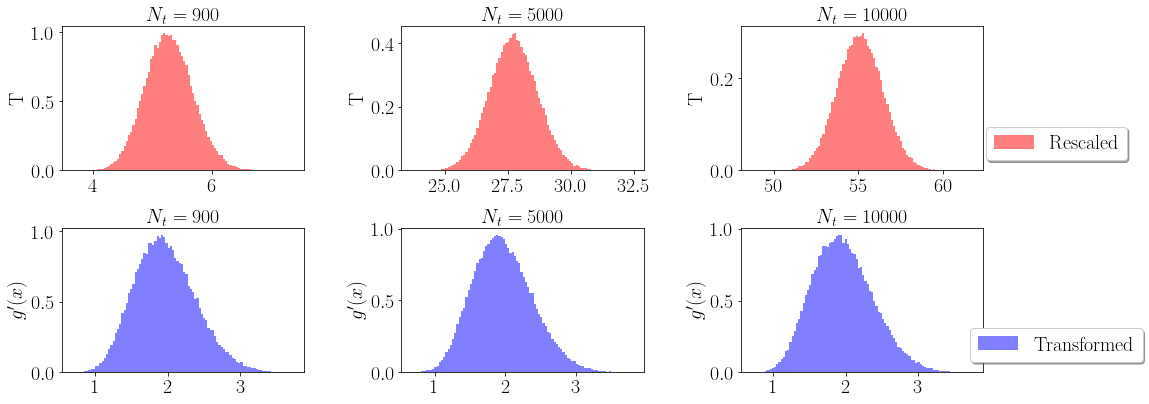

In [93]:

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2, 3,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)


# Non transformed Rescale time 
list_time_900=df_rescaled_moresteps[df_rescaled_moresteps['count']==900]["t"]

# Plot final time reached by the rescaled scheme
var = list_time_900
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="Rescaled",alpha=0.5)
# ax1.set_ylim([0,0.75])
ax1.set_ylabel("T")
ax1.set_title("$N_t=900$")


list_time_5000=df_rescaled_moresteps[df_rescaled_moresteps['count']==5000]["t"]
var = list_time_5000
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="Rescaled",alpha=0.5)
# ax1.set_ylim([0,0.75])
ax2.set_ylabel("T")
ax2.set_title("$N_t=5000$")


list_time_5000=df_rescaled_moresteps[df_rescaled_moresteps['count']==10000]["t"]
var = list_time_5000
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="Rescaled",alpha=0.5)
# ax1.set_ylim([0,0.75])
ax3.set_ylabel("T")
ax3.set_title("$N_t=10000$")
ax3.legend(loc='lower center',bbox_to_anchor=(1.3, 0.),
          ncol=1, fancybox=True, shadow=True)
###################### Corresponding correction in the rescale scheme ###############################

# Non transformed Rescale time 
list_time_900=df_transfo_moresteps[df_transfo_moresteps['count']==900]["gp"]

# Plot final time reached by the rescaled scheme
var = list_time_900
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax4.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Transformed",alpha=0.5)
ax4.set_ylabel("$g'(x)$")
ax4.set_title("$N_t=900$")


list_time_5000=df_transfo_moresteps[df_transfo_moresteps['count']==5000]["gp"]
var = list_time_5000
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax5.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Transformed",alpha=0.5)
ax5.set_ylabel("$g'(x)$")
ax5.set_title("$N_t=5000$")


list_time_5000=df_transfo_moresteps[df_transfo_moresteps['count']==10000]["gp"]
var = list_time_5000
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax6.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Transformed",alpha=0.5)
ax6.legend(loc='lower center',bbox_to_anchor=(1.3, 0.),
          ncol=1, fancybox=True, shadow=True)
ax6.set_ylabel("$g'(x)$")
ax6.set_title("$N_t=10000$")


To do: 
- One could have a look at the accuracy of the transformed SDE with Euler Maruyama compared to the non transformed. 
- One could also plot the evolving distribution with a really tiny counts to be able to compare. Those two items are definitely in the to do list. 


### Look after a fixed time t=T
Now, we will aim at comparing the distribution at special times, in order to be able to compare the rescaled times one. Let's redefine the code using *while t<T*. To compare those codes at different times, it would be good to be able to pick up the best approximation. We select in advance the times at which we wish to save the values of $X, \tilde{X}, Y$. 
We might just look at: 
$$
T=[0.2,0.4,1,5,10,15]
$$

In [119]:
from numba import jit,njit,vectorize, float64, int32, boolean
import numba as nb
import numpy as np
 
##############
# Parameters #
##############
M=5
m=0.01
# includeD=False # if 1 include divergence term
Tl=np.array([0.2,0.4,1,5,10,15])
lenTl = len(Tl)

########################
# Potential parameters #
########################

def U(x):
    """
    potential of -the infinite double well
    """
    x2 = x*x
    
    return (1/(2*x2)+x2)
    
# define the gradV function 
@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

########################
#  Adaptive function G #
########################
@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

# ###################################
# # * Using the hessian definition *#
# ###################################
# @njit(float64(float64))
# def getg_hessian(x): #,dtmin, dtmax, R):
#     gi2 = np.power(x,8)/9
#     xi = np.sqrt(m*m+gi2)
#     g=1./(1./M+1./xi)
#     return g

# @njit(float64(float64))
# def getgprime_hessian(x):
#     gi2 = np.power(x,8)/9
#     xi = np.sqrt(gi2+m*m)
#     x7=gi2/x*4
#     Mxi =np.power((M+xi),2)
#     gprime= x7*M*M/(Mxi*xi)
#     return gprime

####################
#  Numerical method#
####################  

@njit(float64[:,:](int32,float64,float64,int32))
def one_traj_ada(T,dt,tau,include_ada):
    """
    Run the simulation for one sample path
    Input
    -----
    T: int
        final time
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    x = 2 # initial value
    t=0 # initialise time at t=0
    count=0.

    #set up vectors to save results 
    # Nt = int(T/dt)
    size_save =lenTl*10
    ctxg_list =np.zeros((size_save,5))
    save_i=0 

    while t<T:
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)

        # No adaptivity   
        ###############
        if include_ada==0:
            g=1
            gp=0
            gdt=g*dt
            t+=dt
        
        # EM applied to transformed SDE and counts using t+=dt  
        #####################################################
        elif include_ada==1:
            g=getg(x)
            gp=getgprime(x)
            gdt=g*dt
            t+=dt

        # EM applied to non transformed SDE but rescale counts
        #####################################################
        elif include_ada==2:
            g=getg(x)
            gp=0 #do not want to add this term so set it to 0. 
            gdt=g*dt
            t+=gdt


        # Compute the values of next count 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*gdt+np.sqrt(tau*gdt*2)*b1+dt*tau*gp
        count+=1

        #****************************
        #* Save (x) and update time *
        #****************************
        if t>Tl[save_i]:
            ctxg_list[save_i,0]=count
            ctxg_list[save_i,1]=t
            ctxg_list[save_i,2]=x
            ctxg_list[save_i,3]=g
            ctxg_list[save_i,4]=gp


            save_i+=1

    return (ctxg_list)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def nsample_ada(n_samples,T,dt,tau,include_ada): # Function is compiled and runs in machine code

    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        final time
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    include_ada: int
        if include_ada==0 No adaptivity 
        if include_ada==1 EM applied to transformed SDE and counts using t+=dt  
        if include_ada==2 EM applied to non transformed SDE but rescale counts t+=gdt

    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    # Nt = int(T/dt)*10
    nsample_pertraj = lenTl*10 #int(Nt/printskip)
    simctxdt_list=np.zeros((n_samples*nsample_pertraj,6))
    ones_nsample=np.ones(nsample_pertraj)
    for j in range(n_samples):
        ctxg_list =one_traj_ada(T,dt,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        simctxdt_list[start_i:end_i,1:6]=ctxg_list
        simctxdt_list[start_i:end_i,0]=ones_nsample*j
    return simctxdt_list

# compile
q= nsample_ada(1,1,0.1,0.1,0) 

In [120]:
n_samples=10**5
T=16
tau=0.1
h=0.02

# if include_ada==0 No adaptivity 
include_ada=0   
%time ynoada= nsample_ada(n_samples,T,h,tau,include_ada)


CPU times: user 2min 6s, sys: 388 ms, total: 2min 7s
Wall time: 11.1 s


In [124]:
# if include_ada==1 EM applied to transformed SDE and counts using t+=dt  
include_ada=1
%time yemtotranssde= nsample_ada(n_samples,T,h,tau,include_ada)

CPU times: user 4min 42s, sys: 639 ms, total: 4min 43s
Wall time: 25.1 s


In [125]:
# if include_ada==2 EM applied to non transformed SDE but rescale counts t+=gdt
include_ada=2
%time yemtonontranssde= nsample_ada(n_samples,T,h,tau,include_ada)

CPU times: user 11min 29s, sys: 654 ms, total: 11min 30s
Wall time: 1min 4s


In [114]:
n_samples=10**5
T=16
tau=0.1
h=0.0001

# if include_ada==0 No adaptivity 
include_ada=0   
%time ynoada_true= nsample_ada(n_samples,T,h,tau,include_ada)

(6000000, 6)
CPU times: user 4h 52min 39s, sys: 15.8 s, total: 4h 52min 55s
Wall time: 25min 47s


In [115]:
np.savetxt("ynoada_ns105T15tau01h00001.txt", ynoada_true)

In [126]:
np.savetxt("ynoada_ns105T15tau01h001.txt", ynoada)
np.savetxt("yemtotranssde_ns105T15tau01h001.txt", yemtotranssde)
np.savetxt("yemtonontranssde_ns105T15tau01h001.txt", yemtonontranssde)


In [127]:

# ynoada=np.loadtxt("ynoada_ns105T15tau01h001.txt")
# yemtotranssde=np.loadtxt("yemtotranssde_ns105T15tau01h001.txt")
# yemtonontranssde=np.loadtxt("yemtonontranssde_ns105T15tau01h001.txt")
ynoada_true=np.loadtxt("ynoada_ns105T15tau01h00001.txt")


In [151]:
import pandas as pd
df_ynoada = pd.DataFrame(ynoada,columns=["sim","step","t","x","g","gp"])
df_yemtotranssde = pd.DataFrame(yemtotranssde,columns=["sim","step","t","x","g","gp"])
df_yemtonontranssde = pd.DataFrame(yemtonontranssde,columns=["sim","step","t","x","g","gp"])
df_ynoada_true = pd.DataFrame(df_ynoada_true,columns=["sim","step","t","x","g","gp"])
df_ynoada_true['step']=np.round((df_ynoada_true['t']/0.0001))


In [152]:
df_ynoada=df_ynoada[df_ynoada['t']!=0]
df_yemtotranssde=df_yemtotranssde[df_yemtotranssde['t']!=0]
df_yemtonontranssde=df_yemtonontranssde[df_yemtonontranssde['t']!=0]
df_ynoada_true=df_ynoada_true[df_ynoada_true['t']!=0]

In [153]:
df_ynoada['count'] = df_ynoada.groupby(['sim']).cumcount()+1
df_yemtotranssde['count'] = df_yemtotranssde.groupby(['sim']).cumcount()+1
df_yemtonontranssde['count'] = df_yemtonontranssde.groupby(['sim']).cumcount()+1
df_ynoada_true['count'] = df_ynoada_true.groupby(['sim']).cumcount()+1


In [154]:
df_ynoada.head(20)

,sim,step,t,x,g,gp,count
0,0.0,11.0,0.22,1.298970,1.0,0.0,1
1,0.0,20.0,0.40,0.969224,1.0,0.0,2
2,0.0,50.0,1.00,0.810996,1.0,0.0,3
3,0.0,251.0,5.02,1.156947,1.0,0.0,4
4,0.0,501.0,10.02,0.792042,1.0,0.0,5
5,0.0,751.0,15.02,0.716167,1.0,0.0,6
60,1.0,11.0,0.22,1.116288,1.0,0.0,1
61,1.0,20.0,0.40,1.001592,1.0,0.0,2
62,1.0,50.0,1.00,1.029986,1.0,0.0,3
63,1.0,251.0,5.02,0.908844,1.0,0.0,4


In [155]:
df_yemtonontranssde.head(20)

,sim,step,t,x,g,gp,count
0,0.0,5.0,0.224066,1.384825,1.738225,0.0,1
1,0.0,11.0,0.418675,1.345508,1.580037,0.0,2
2,0.0,57.0,1.003223,0.886379,0.519231,0.0,3
3,0.0,457.0,5.002642,0.674742,0.309576,0.0,4
4,0.0,975.0,10.008180,0.854672,0.475834,0.0,5
5,0.0,1468.0,15.002639,0.768829,0.414554,0.0,6
60,1.0,4.0,0.203592,1.312604,2.135747,0.0,1
61,1.0,13.0,0.410274,0.958733,0.968232,0.0,2
62,1.0,61.0,1.006975,0.939635,0.532845,0.0,3
63,1.0,416.0,5.007319,0.911717,0.753193,0.0,4


In [156]:
df_yemtonontranssde.head(20)

,sim,step,t,x,g,gp,count
0,0.0,5.0,0.224066,1.384825,1.738225,0.0,1
1,0.0,11.0,0.418675,1.345508,1.580037,0.0,2
2,0.0,57.0,1.003223,0.886379,0.519231,0.0,3
3,0.0,457.0,5.002642,0.674742,0.309576,0.0,4
4,0.0,975.0,10.008180,0.854672,0.475834,0.0,5
5,0.0,1468.0,15.002639,0.768829,0.414554,0.0,6
60,1.0,4.0,0.203592,1.312604,2.135747,0.0,1
61,1.0,13.0,0.410274,0.958733,0.968232,0.0,2
62,1.0,61.0,1.006975,0.939635,0.532845,0.0,3
63,1.0,416.0,5.007319,0.911717,0.753193,0.0,4


In [157]:
df_ynoada_true.head(20)

,sim,step,t,x,g,gp,count
0,0.0,2000.0,0.2,1.389869,1.0,0.0,1
1,0.0,12000.0,1.2,0.779858,1.0,0.0,2
2,0.0,22000.0,2.2,0.969413,1.0,0.0,3
3,0.0,32000.0,3.2,0.905488,1.0,0.0,4
4,0.0,42000.0,4.2,1.075668,1.0,0.0,5
5,1.0,2000.0,0.2,1.403788,1.0,0.0,1
6,1.0,12000.0,1.2,0.797693,1.0,0.0,2
7,1.0,22000.0,2.2,1.000686,1.0,0.0,3
8,1.0,32000.0,3.2,0.878842,1.0,0.0,4
9,1.0,42000.0,4.2,1.014348,1.0,0.0,5


In [158]:
list_count = df_ynoada_true['count'].unique()

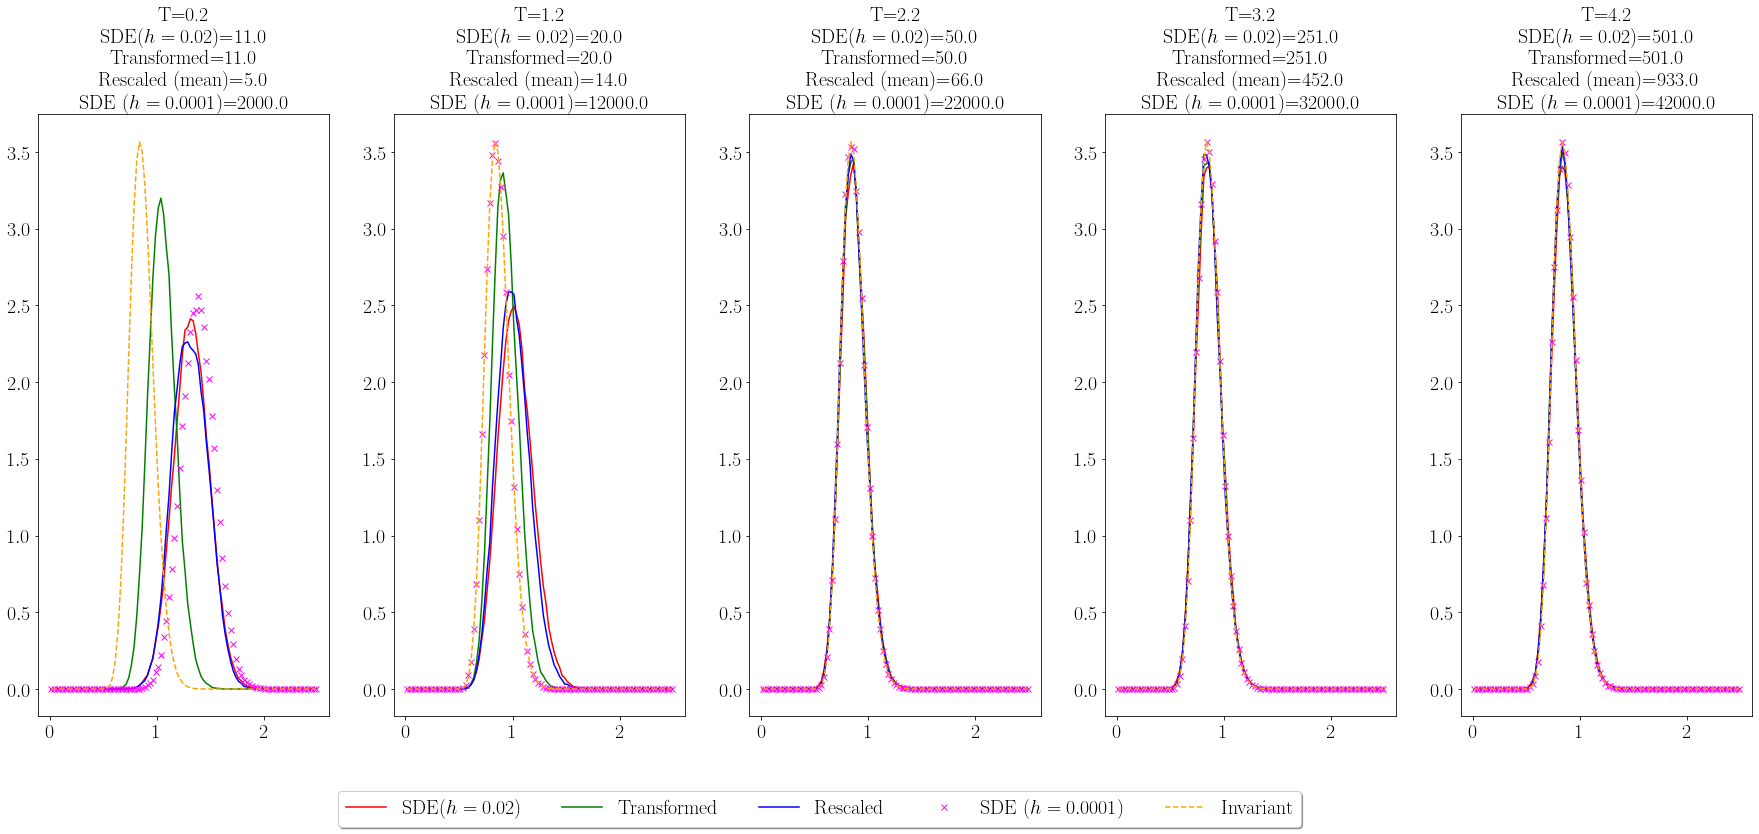

In [169]:
## Set up the plots 
fig, ((axs))= plt.subplots(1,len(list_count),figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# fig.suptitle('Overdamped - evolving distributions (M='+str(M)+' and m=' +str(m)+")", fontsize=25)
fig.tight_layout(rect=[0, 0.01, 1, 0.95])
## Loop through the values 
for i in range(len(list_count)):
    
    counti = i+1
    # * 
    df_ynoada_i=df_ynoada[df_ynoada['count']==counti]
    # ti_noada=df_ynoada_i['t'].unique()[0]
    
    # * 
    df_yemtotranssde_i=df_yemtotranssde[df_yemtotranssde['count']==counti]
    # ti_emtotranssde=df_yemtotranssde_i['t'].unique()[0]

    # * 
    df_yemtonontranssde_i=df_yemtonontranssde[df_yemtonontranssde['count']==counti]

    # * 
    df_ynoada_true_i = df_ynoada_true[df_ynoada_true['count']==counti]

    # --- Q at time t=ti hessian
    histogram,bins = np.histogram(df_ynoada_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label="SDE($h=0.02$)",color="red")

    # --- Q at time t=ti first derivative
    histogram,bins = np.histogram(df_yemtotranssde_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label="Transformed",color="green")

    # --- Q at time t=ti not adaptive
    histogram,bins = np.histogram(df_yemtonontranssde_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,label="Rescaled",color="blue")

    # --- Q at time t=ti not adaptive
    histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx_q,histogram,"x",label='SDE ($h=0.0001$)',color="magenta")

    # --- Q true
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[i].plot(midx_q,rho,'--',label='Invariant',color="orange")
    nrescaled = str(np.round(df_yemtonontranssde_i['step'].mean(),0))
    titlei="T="+str(round(df_ynoada_true_i['t'].unique()[0],2))+"\n SDE($h=0.02$)="+str(df_ynoada_i['step'].unique()[0])+"\n Transformed="+str(df_yemtotranssde_i['step'].unique()[0])+"\n Rescaled (mean)="+str(np.round(df_yemtonontranssde_i['step'].mean(),0))+"\n SDE ($h=0.0001$)="+str(df_ynoada_true_i['step'].unique()[0])
    axs[i].set_title(titlei)

axs[len(Tl)-2].legend(loc='lower center',bbox_to_anchor=(-2.2, -0.2),ncol=5, fancybox=True, shadow=True)


# fig.savefig('UptoTM'+str(M)+"m"+str(m)+"T"+str(15)+"h"+str(h)+"tau"+str(tau)+".png")

Look at the distribution after a finite number of counts, large enough that we could hope we have reach the final distribution. 

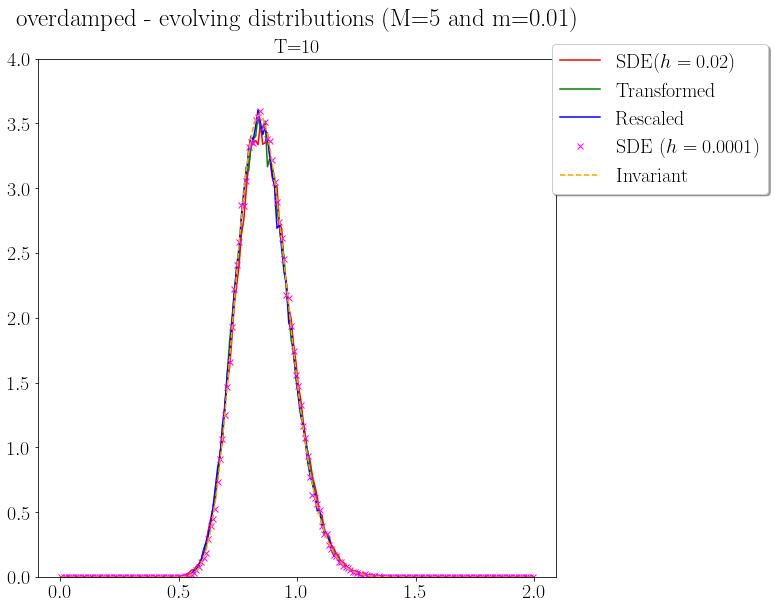

In [174]:
## Set up the plots 
fig, ((axs))= plt.subplots(1,1,figsize=(9,9))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('overdamped - evolving distributions (M='+str(M)+' and m=' +str(m)+")", fontsize=25)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
## Loop through the values 
    
# List of time
counti = 5
# * Dataframe using hessian
df_ynoada_i=df_ynoada[df_ynoada['count']==counti]
# * Dataframe using first derivative 
df_yemtotranssde_i=df_yemtotranssde[df_yemtotranssde['count']==counti]
# * Dataframe using no adaptivity 
df_yemtonontranssde_i=df_yemtonontranssde[df_yemtonontranssde['count']==counti]

# * Dataframe 
df_ynoada_true_i=df_ynoada_true[df_ynoada_true['count']==counti]
    
nbins=200
# --- Q at time t=ti hessian
histogram,bins = np.histogram(df_ynoada_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,label="SDE($h=0.02$)",color="red")

# --- Q at time t=ti first derivative
histogram,bins = np.histogram(df_yemtotranssde_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,label='Transformed',color="green")

# --- Q at time t=ti not adaptive
histogram,bins = np.histogram(df_yemtonontranssde_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,label="Rescaled",color="blue")

# --- Q at time t=ti not adaptive
histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=nbins,range=[0,2], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
axs.plot(midx_q,histogram,"x",label='SDE ($h=0.0001$)',color="magenta")


# --- Q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
axs.plot(midx_q,rho,'--',label='Invariant',color="orange")
axs.set_title("T="+str(np.round(10)),fontsize= 20)
axs.set_ylim([0, 4])

axs.legend(loc='lower center',bbox_to_anchor=(1.2, 0.72),ncol=1, fancybox=True, shadow=True)

fig.savefig('final_distrM'+str(M)+"m"+str(m)+"T"+str(T)+"h"+str(h)+"tau"+str(tau)+".png")